# Imports

In [2]:
from numpy.random import seed
seed(888)

# from tensorflow import set_random_seed
# set_random_seed(404)

import tensorflow
tensorflow.random.set_seed(404)

In [3]:
import os
import numpy as np
import tensorflow as tf
import itertools

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from IPython.display import display
from keras.preprocessing.image import array_to_img
from keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt

%matplotlib inline

# Constants

In [4]:
LOG_DIR = 'tensorboard_cifar_logs/'

LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
NR_CLASSES = 10

VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

# Get the Data

In [5]:
# First, we download the data:

(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

In [6]:
type(cifar10) # -> module
type(x_train_all)

numpy.ndarray

# Explore the Data

In [7]:
# First way to display an image in Jupyter notebook: 
# python display

In [8]:
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

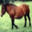

In [9]:
pic = array_to_img(x_train_all[7])
display(pic)

In [10]:
# We can verify that the image above is above by looking at the image labels which we found in the y labels: 

y_train_all.shape # -> (50000, 1)
# so the y value at index 7 is: 

y_train_all[7][0]
# This is the index of the word, we can see in the cell below

7

In [11]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

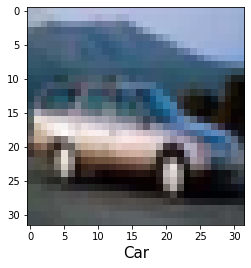

In [12]:
# Second way to display an image in Jupyter notebook: 
# matplotlib

plt.imshow(x_train_all[4])
plt.xlabel(LABEL_NAMES[y_train_all[4][0]], fontsize=15)
plt.show()

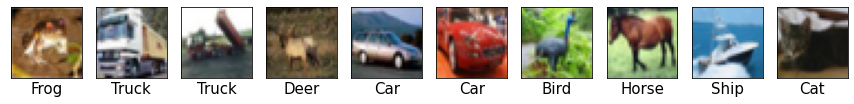

In [13]:
# Challenge:
# Write a for loop to display the first 10 images from the ```x_train_all``` array in a row. 
# Show the name of the label below the picture. Remove the ugly tick marks.
# *Hint* use matplotlib. 

plt.figure(figsize=[15, 5])

for i in range(10):
    plt.subplot(1,10,i+1) 
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(LABEL_NAMES[y_train_all[i][0]], fontsize=15)
    # plt.show() -> si pones esto te imprimirá cada foto en una fila distinta
    plt.imshow(x_train_all[i])


In [14]:
#Format of the image: RGB
x_train_all[0].shape

(32, 32, 3)

In [15]:
nr_images, x, y, c = x_train_all.shape
print(f'nr_images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

nr_images = 50000 	| width = 32 	| height = 32 	| channels = 3


In [16]:
x_test.shape

(10000, 32, 32, 3)

# Preprocess Data

In [17]:
type(x_train_all[0][0][0][0])
# uint8 -> 8 bit unsigned(like valor absoluto) integer

numpy.uint8

In [18]:
# We transform the range from 0-255 (int) to 0-1 (float)
# this will help us when we need to calculate the loss, adjusting weights ...

x_train_all, x_test = x_train_all / 255.0, x_test / 255.0

In [19]:
type(x_train_all[0][0][0][0])

numpy.float64

In [20]:
# Now we are gonna flatten our data, that is,
# we are going to put the values in a single row,
# so we have a single row of numbers to represent one image:

x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUTS)
# In X[0] we have all the first image pixels rgb

In [21]:
x_train_all.shape

(50000, 3072)

In [22]:
x_test = x_test.reshape(len(x_test), TOTAL_INPUTS)
print(f'Shape of x_test is {x_test.shape}')

Shape of x_test is (10000, 3072)


### Create Validation Dataset

> We have:  
>> data = training_data + test_data  
>
> Now we are going to plit the training_data into two:  
>> training_data = training_data + **validation_data**  
>
> We do this as with the workflow we will make little changes in the model,  
> and the validation dataset will allow us to then select our best model,  
> as the valuation dataset is to evaluate the little tweaks/changes
>
> When we work with small data sets we usually use:  
>> 60% training dat, 20% validation_data, 20% test_data  
>
> If we have absolutely enormous amount of data then:  
>> 1% validation_data and 1% test_data

In [23]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]
x_val.shape

(10000, 3072)

In [24]:
# Challenge:
# Create two numpy arrays ```x_train``` and ```y_train``` 
# that have the shape (40000, 3072) and (40000, 1) respectively.
# They need to contain the last 40000 values from ```x_train_all``` and ```y_train_all``` respectively. 


x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]
print(x_train.shape)
print(y_train.shape)


(40000, 3072)
(40000, 1)


### Create a small dataset (for illustration)

> As we don't want to put to much work our computer, we will first train with a small dataset.  
> After we are happy, we eill continue training but with the bigger dataset.

In [25]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

# Define the Neural Network using Keras  

When we work with Tensorflow (that is the backend for Keras), we will have 3 steps to build our model:  
>
> ***1. Define the model:*** Set out the structure of the model  
>
> ***2. Compiling the model:*** Tell Tensorflow in advance how do we want to measure the loss, the calculations we want for the weight ...  
>
> ***3. Fit:*** Training the model
  
We will work with the ***MULTILAYER PERCEPTRON***, a simple neural network.  

***STEP 1: DEFINE***  
  
> Then, for step 1, defining our model, we will set up the architecture for this perceptron.  
This mean creating the layers.  

> The ***first layer*** we create is not the imput layer but the first hidden layer.  
We need to tell Keras how many imputs does this layer have.  
As we are working with images, this number is determined by the resolution and the color space of the image.  
(width * length * color -> $32*32*3$ in our case)  
To create this layer we need the function:  
>> **Dense(nr_neurons, nr_imputs, activation_function, layer_name(optional))**  
>>  
We have to specify nr_imputs = $32*32*3$ as it is the first layer  
The activation function is how the neurons are going to behave  

>For the ***second layer*** we use the same function but without nr_imputs, and its nr_neurons (activation function remains the same).  

>When we reach the ***output layer*** we will use nr_imputs and a different activation_function: softmax  
This activation function will transform our outputs into a probability (so we can interpret them).  
It will give us a distribution for all the output numbers: they are all between 0 and 1, and they sum 1.

> So to create our model we use:  
>> **model_name = Sequential([ Dense_first_layer, Dense_second_layer, ... Dense_output_layer])**  
>>(Look at model_1)
>
> or:  
>> **model_2 = Sequential()  
model_2.add(Dense_first_layer)  
model_2.add(Dense_second_layer)  
...  
model_2.add(Dense(10_output_layer)***  
>> (Look at model_2)

***STEP 2: COMPILE***  
  
> Now we have to compile our model, that is, telling  Tensorflow about the kind of calculations we will have to do down the line, so tensorflow can create its graph behind the scenes.  
  
> In this calculations we can find the loss (with the loss/cost function), so we can calculate how fas is our model from the true value.  
And the model will have to update the weights as it is being train, or calculate the accuracy so we can see how it improves over time.  

> In Regression models we saw the MSE (Mean Square Error), but we have many more.  
As we are not doing a regression but a classification with multiple classes, with a probability associated to each class,  
we will use the ***CATEGORICAL CROSS ENTROPY***, that provides a probability between 0 and 1 as an output.
>
>> $$ CE = - \sum_{i} \big( y_i log( \hat{y_i}) \big)$$ 
>> where:
>> - $y_i$ is the actual value of the label (0 or 1)
>> - $\hat{y_i}$ is the predicted probability
>> - i is one of the categories, so we sum all the categories
>  
> Example:   
>>Imagine we have a model that tell us if a picture has a cat or not.  
We have 2 categories   
We provide a photo with a cat($ y_1 = 1$ , $y_0 = 0$), and it tells us that it has a cat ($\hat{y_1} = 1$), then the CE would be:  
>>  
>> $ CE = - (y_0 log( \hat{y_0} + y_1 log( \hat{y_1}) = - (0 * log(0)+ 1 * log(1)) = - (0*1 + 1*0) = 0$

> Now, to compile in jupyter using Keras we need the function:  
>> **our_model_name.compile( optimizer, loss_function, metric)**

***OPTIMIZER***
> An algorithm that calculates the loss and adjusts the weights.  
  
> As researchers were looking to come up with a better solution than the Gradient Descent, or how could it be improved, they were looking essentially a better way to optimize the cost. As a result, we have now a variety of optimizer to choose from.   
> Look at the Keras documentation to look at what we have got available to us.

> A really popular optimizer is: **Adam**  
> It is very computationally efficient, it has very low memory requirements and it requires very little configuration.

***BIAS***
> The **ACTIVATION FUNCTION** determines how strong our neuron will fire.   
> We had different types of activation functions, like the sigmoid.  
> (Yo) Imagine this is: f  

> Now, when we change the connection **WEIGHTS**, we are changing the activation function, making it steeper or flatter (for ex)  
> (Yo) if the weight = a, this would be like: a*f

> Finally, if we want to move the activation function we use the **BIAS**.  
> (Yo) bias = b, then: a*f + b

Now, all of these are **parameters** that the neural network can update

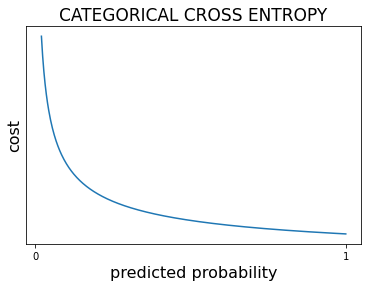

In [26]:
#YO!!!
# CATEGORICAL CROSS ENTROPY graph:

# This is not the actual function, but one I found with a similar graph to show the example
def f(x):
    return 1/(x**0.5)

x = np.linspace(start= 0.02, stop = 1, num = 500)
plt.yticks([])
plt.xticks([0,1])
plt.title('CATEGORICAL CROSS ENTROPY', fontsize = 17)
plt.xlabel('predicted probability', fontsize = 16)
plt.ylabel('cost', fontsize = 16)
plt.plot(x, f(x))
plt.show()

# If the probability is near 0, we see that the cost/loss funtion really penalizes the predictions
# Instead, as the probability is near 1, the cost/loss function decreases to 0
# So this cost function really penalizes the predictions that are both, confident and wrong

In [27]:
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
    Dense(units=64, activation='relu', name='m1_hidden2'),
    Dense(16, activation='relu', name='m1_hidden3'),
    Dense(10, activation='softmax', name='m1_output')
])

model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
# sparse_categorical_crossentropy is a slightly more computationally efficient variation
# of the Categorical Cross Entropy that Keras gives us.

#type(model_1) -> keras.engine.sequential.Sequential

In [28]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m1_hidden1 (Dense)           (None, 128)               393344    
_________________________________________________________________
m1_hidden2 (Dense)           (None, 64)                8256      
_________________________________________________________________
m1_hidden3 (Dense)           (None, 16)                1040      
_________________________________________________________________
m1_output (Dense)            (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Let's analize the total number of parameters in our model:

# FIRST LAYER:
#  Inputs = 32 *32 *3
#  neurons = 128
#   nr_connection_weights = 32*32*3*128 = 393216 < 393344
#  bias = 128 
#   nr_connection_weights = 3393216 + 128 = 393344

# SECOND LAYER: analogous ...

(32*32*3*128 + 128) + (128*64 + 64) + (64*16 + 16) + (16*10 + 10)

402810

In [30]:
model_2 = Sequential()
model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
# we used the regularisation Dropout(see below) to prevent over fitting
# 0.2, probability of dropout a neuron of the first layer (as it is before)
model_2.add(Dense(128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(15, activation='relu', name='m2_hidden3'))
model_2.add(Dense(10, activation='softmax', name='m2_output'))

model_2.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [31]:
# Challenge:
# Create a third model, ```model_3``` that has two dropout layers.
# The second dropout layer should be added after the first hidden layer and have a dropout rate of 25%. 

model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_3.add(Dense(128, activation='relu', name='m3_hidden1'))
model_3.add(Dropout(0.25, seed=42))
model_3.add(Dense(64, activation='relu', name='m3_hidden2'))
model_3.add(Dense(15, activation='relu', name='m3_hidden3'))
model_3.add(Dense(10, activation='softmax', name='m3_output'))

model_3.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

# Tensorboard (visualising learning)
 > To visualice it we put on the terminal:  
 >> tensorboard --logdir= (directory of the folder  tensorboar_cifar_logs, where we have the different models)  
 >>  
 >> tensorboard --logdir=C:\Users\evama\Documents\AI\Udemy_ML_and_data_science\Udemy_Notes_ML\10_Neural_Nets_Keras_CIFAR10_Classification\tensorboard_cifar_logs  
 
 > Then, it will return a web like: http://localhost:6006/  
 >> Copy it (ctrl+shift+C) and paste it in the navigator

In [32]:
def get_tensorboard(model_name):

    folder_name = f'{model_name} at {strftime("%H %M")}' #To print the hour
    dir_paths = os.path.join(LOG_DIR, folder_name) #Create the path #os module: operating system

    #Now we are going to create a directory including a subdirectory, that is, 2 folders.
    try:
        os.makedirs(dir_paths) #this create the directory, with the subdirectory
                               #but if you created it before, it may get an error, that is why we use try. 
    except OSError as err:     #If it has this error, we convert it into string and print it
        print(err.strerror)
    else:
        print('Successfully created directory')
    return TensorBoard(log_dir=dir_paths)

# Fit the Model

***EPOCHS***  
>An ***epoch*** is when the entire dataset has been passed through the neural network a single time.  
But as these methods work, we need to pass the dataset many times.  

>But, what if we have a huge dataset?  
>> If the computer is powerful enough or the dataset small enough for your computer, you can process all the data at once.  
>>Otherwise, we need to split our training data and process one piece of it at a time.

A single piece of the dataset is called a ***BATCH***.
>So if you split your dataset, then you will train your model on 1 batch at a time, meaning that it will take multiple iterations to go through the entire dataset.  
The formula for the umber of iterations that it takes to chew through the entire dataset is:  

$$Iterations = \frac{Nr \: of \: Training \: Samples}{Batch \: Size}$$

***OVERFITTING***

>You can detect it when:
>> - the loss/cost on the **validation dataset** stops drecresing or starts to increase
>> - the accuracy of the validation dataset differs from the training dataset one

> How can we fix it?  
> The techniques for preventing overfitting are called ***REGULARISATION***.
>(you can look at them: https://keras.io/callbacks/)  
>Some examples are:
>> - ***EarlyStopping***: The model stops training when some quantity (ex: validation loss) stops improving   
>> - ***Dropout***: You can ignore some neurons during the training. During the next training step, a different neuron might drop out and so on.

In [33]:
samples_per_batch = 1000

In [34]:
# %%time

#See lecture  166 to see how do we use Tendorboard

# nr_epochs = 150
# model_1.fit(x_train_xs, y_train_xs, batch_size=samples_per_batch, epochs=nr_epochs,
#             callbacks=[get_tensorboard('Model 1')], verbose=0, validation_data=(x_val, y_val))

In [35]:
# %%time
# nr_epochs = 150
# model_2.fit(x_train_xs, y_train_xs, batch_size=samples_per_batch, epochs=nr_epochs,
#             callbacks=[get_tensorboard('Model 2')], verbose=0, validation_data=(x_val, y_val))

In [36]:
%%time
nr_epochs = 100
model_1.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs,
            callbacks=[get_tensorboard('Model 1 XL')], verbose=0, validation_data=(x_val, y_val))

Successfully created directory
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Wall time: 51.6 s


In [37]:
%%time
nr_epochs = 100
model_2.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs,
            callbacks=[get_tensorboard('Model 2 XL')], verbose=0, validation_data=(x_val, y_val))

Successfully created directory
Wall time: 1min 52s


In [38]:
%%time
nr_epochs = 100
model_3.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs,
            callbacks=[get_tensorboard('Model 3 XL')], verbose=0, validation_data=(x_val, y_val))

Successfully created directory
Wall time: 1min 56s


# Predictions on Individual Images

In [39]:
x_val[0].shape #We can see that the image is flattened, so we will make it 2 dimensional again:

(3072,)

In [40]:
test = np.expand_dims(x_val[0], axis=0)
test.shape

(1, 3072)

In [41]:
np.set_printoptions(precision=3)

In [42]:
model_2.predict(test)

array([[0.068, 0.056, 0.066, 0.111, 0.17 , 0.119, 0.276, 0.132, 0.   ,
        0.001]], dtype=float32)

In [43]:
model_2.predict(x_val).shape

(10000, 10)

In [44]:
model_2.predict_classes(test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([6], dtype=int64)

In [45]:
y_val[0]

array([6], dtype=uint8)

**Challenge:** Write a for loop where you print out the actual value and the predicted value for the first 10 images in the valuation dataset. 

In [46]:
for number in range(10):
    test_img = np.expand_dims(x_val[number], axis=0)
    predicted_val = model_2.predict_classes(test_img)[0]
    print(f'Actual value: {y_val[number][0]} vs. predicted: {predicted_val}')

Actual value: 6 vs. predicted: 6
Actual value: 9 vs. predicted: 1
Actual value: 9 vs. predicted: 9
Actual value: 4 vs. predicted: 6
Actual value: 1 vs. predicted: 8
Actual value: 1 vs. predicted: 1
Actual value: 2 vs. predicted: 6
Actual value: 7 vs. predicted: 7
Actual value: 8 vs. predicted: 8
Actual value: 3 vs. predicted: 9


# Evaluation

In [47]:
model_2.metrics_names

['loss', 'accuracy']

In [48]:
test_loss, test_accuracy = model_2.evaluate(x_test, y_test)
print(f'Test loss is {test_loss:0.3} and test accuracy is {test_accuracy:0.1%}')

313/313 [==============================] - 0s 1ms/step - loss: 1.4176 - accuracy: 0.5030
Test loss is 1.42 and test accuracy is 50.3%


### Confusion Matrix

In [49]:
predictions = model_2.predict_classes(x_test)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

In [50]:
conf_matrix.shape

(10, 10)

In [51]:
nr_rows = conf_matrix.shape[0]
nr_cols = conf_matrix.shape[1]

In [52]:
conf_matrix.max()

693

In [53]:
conf_matrix.min()

5

In [54]:
conf_matrix[0]

array([626,  30,  37,  16,  33,  17,  14,  29, 159,  39], dtype=int64)

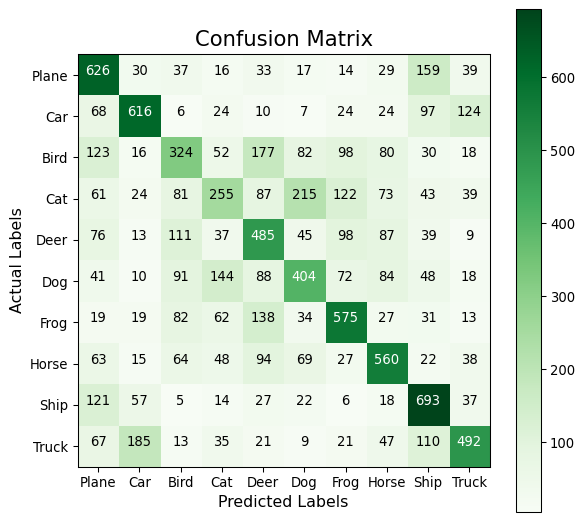

In [55]:
plt.figure(figsize=(7,7), dpi=95)
plt.imshow(conf_matrix, cmap=plt.cm.Greens)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

tick_marks = np.arange(NR_CLASSES)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)

plt.colorbar()

for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center',
            color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')
    

plt.show()

**Challenge:** What do the numbers down the diagonal represent? What do the other numbers (excluding the number in the diagonal) in a single row represent? Try to identify the false positives, false negatives, and the true positives in the confusion matrix.

In [56]:
# True Positives
# 581 images with planes have been labeled as planes
np.diag(conf_matrix)

#The false positives are the columns values except the diagonal
#The false negatives are the rows values except the diagonal

array([626, 616, 324, 255, 485, 404, 575, 560, 693, 492], dtype=int64)

In [57]:
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall

array([0.626, 0.616, 0.324, 0.255, 0.485, 0.404, 0.575, 0.56 , 0.693,
       0.492])

In [58]:
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision

array([0.495, 0.625, 0.398, 0.371, 0.418, 0.447, 0.544, 0.544, 0.545,
       0.595])

In [59]:
avg_recall = np.mean(recall)
print(f'Model 2 recall score is {avg_recall:.2%}')

Model 2 recall score is 50.30%


**Challenge:** Calculate the average precision for the model as a whole. Print this out. Then calculate the f-score for the model as a whole. 

In [60]:
avg_precision = np.mean(precision)
print(f'Model 2 precision score is {avg_precision:.2%}')

f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
print(f'Model 2 f score is {f1_score:.2%}')

Model 2 precision score is 49.82%
Model 2 f score is 50.06%
